<div> <center><img src="https://storage.googleapis.com/open-ff-common/openFF_logo.png" width="100"/></div>
<h1><center>Proprietary notebook - Aug 2023</center></h1>

In [46]:
!git clone https://github.com/gwallison/intg_support.git &>/dev/null;
!pip install itables  &>/dev/null;
!pip install geopandas  &>/dev/null;

import urllib
urllib.request.urlretrieve('https://storage.googleapis.com/gwa-test/georef-united-states-of-america-county.geojson',
                            'counties.geojson')

('./tmp/counties.geojson', <http.client.HTTPMessage at 0x1c107f6a380>)

In [32]:
%run intg_support/local_frack_steps.py

<IPython.core.display.Javascript object>

In [18]:
# get full set of data
import intg_support.geo_tools as gt
work_dir = ''
get_fulldf(work_dir=work_dir) # this downloads most recent from the web.
df = get_df(os.path.join(work_dir,'full_df.parquet'))
df = df[df.in_std_filtered]

In [19]:
# make a proprietary only data set
prop_df = df[df.bgCAS=='proprietary'].copy()


# show all the Purpose fields
You could also look at the [Browser's version](https://storage.googleapis.com/open-ff-browser/proprietary/analysis_proprietary.html#raw) of this.  Extra long purposes (using indicating multiple products) are truncated and combined.  They are not very useful...

In [20]:
prop_df.groupby('Purpose',as_index=False).size()

Purpose  size
0        \nAcid Gelling Agent\n     1
1          \nFriction Reducer\n     1
2         "Other Ingredient(s)"    49
3           (Other Ingredients)    56
4           *3rd Party Additive   182
...                         ...   ...
2059             synthetic acid     1
2060                    unknown     1
2061                    various    13
2062      viscosifier for water     6
2063  water recovery surfactant    10

[2064 rows x 2 columns]

# make graphs of operators and suppliers

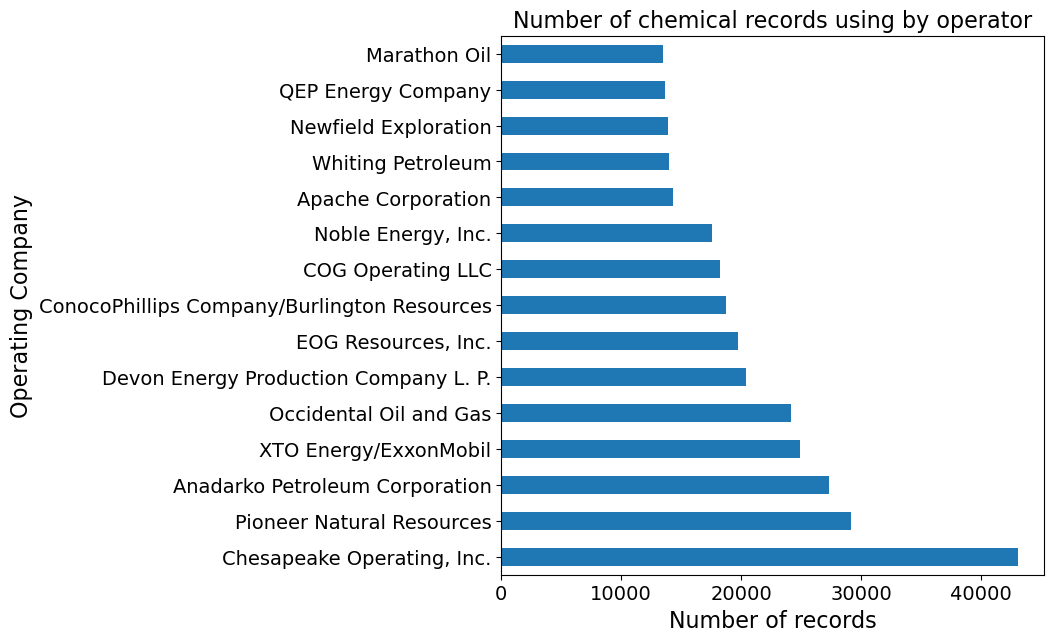

In [26]:
import matplotlib.pyplot as plt
# cas = prop_df.bgCAS.iloc[0]
# use the most common name given in FF for the label
gb1 = prop_df.groupby('bgOperatorName')['OperatorName'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgOperatorName','op_common']
mg = pd.merge(prop_df,gb1,on='bgOperatorName',how='left')
ax = mg.groupby('op_common')['UploadKey'].count()\
         .sort_values(ascending=False)[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Operating Company',fontsize=16);
plt.title(f'Number of chemical records using by operator',fontsize=16);

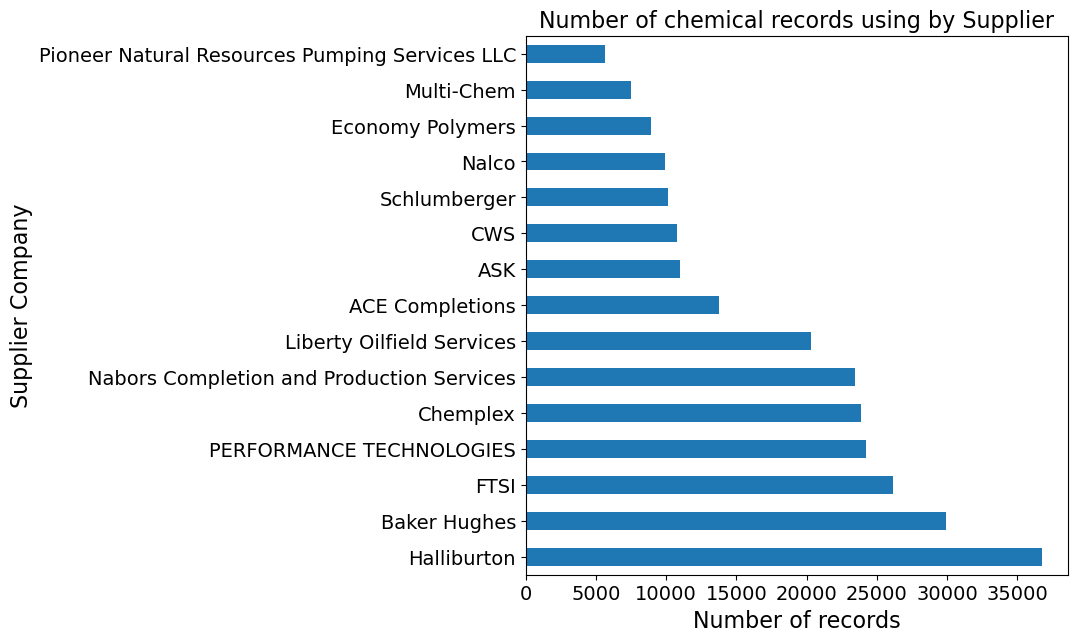

In [28]:
# records to exclude
not_comp = ['MISSING','Listed Above']

gb1 = prop_df.groupby('bgSupplier')['Supplier'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgSupplier','sup_common']
mg = pd.merge(prop_df,gb1,on='bgSupplier',how='left')

mg = mg[~mg.sup_common.isin(not_comp)]

ax = mg.groupby('sup_common')['UploadKey'].count()\
         .sort_values(ascending=False)[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Supplier Company',fontsize=16);
plt.title(f'Number of chemical records using by Supplier',fontsize=16);

In [43]:
import geopandas as gpd
import folium
import numpy as np

def fix_county_names(df):
    trans = {'mckenzie':'mc kenzie',
             'dewitt':'de witt',
             'mcclain':'mc clain',
             'mcintosh':'mc intosh',
             'mckean':'mc kean',
             'mcmullen':'mc mullen'}
    for wrong in trans.keys():
        df.CountyName = np.where(df.CountyName==wrong,trans[wrong],df.CountyName)
    return df

def create_county_choropleth(data,
                             start_loc=[40, -96],start_zoom = 6,
                             custom_scale = [], plotlog = True,
                             legend_name = 'Test legend',
                             show_only_data_states=True,
                             #popup_enabled=True, tooltip_enabled=False,
                             fields = ['CountyName','orig_value'],
                             aliases = ['County: ','data: ']):
    fn = r"counties.geojson"
    if len(data)<1:
        print('No mappable data')
        return
    geojson = gpd.read_file(fn)
    data['orig_value'] = data.value

    geojson['StateName'] = geojson.ste_name.str.lower()
    geojson['CountyName'] = geojson.coty_name.str.lower()
    geojson = fix_county_names(geojson)
    working = geojson[['StateName','CountyName','coty_code','geometry']]
    #geojson = geojson.to_crs(5070)
    working = pd.merge(working,data,on=['StateName','CountyName'],how='left')
    #print(geojson.info())
    if start_loc==[]:
        start_loc = [geojson.geometry.centroid.x.mean(),geojson.geometry.centroid.y.mean()]
    f = folium.Figure(width=600, height=400)
    m = folium.Map(location= start_loc, tiles="openstreetmap",
                   zoom_start=start_zoom).add_to(f)
    if plotlog:
        working.value = np.log10(working.value+1)
        legend_name = legend_name + ' (log transformed)'
    working.orig_value.fillna('no data',inplace=True)
    
    if custom_scale==[]:
        custom_scale = (working['value'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
    if show_only_data_states:
        gb = data.groupby(['StateName','CountyName'],as_index=False)['value'].first()
        datalst = []
        for i,row in gb.iterrows():
            datalst.append((row.StateName,row.CountyName))
        wlst = []
        working['tup'] = list(zip(working.StateName.tolist(),working.CountyName.tolist()))
        geojson['tup'] = list(zip(geojson.StateName.tolist(),geojson.CountyName.tolist()))
        
#         working = working[working.StateName.isin(data.StateName.unique().tolist())]
#         geojson = geojson[geojson.StateName.isin(data.StateName.unique().tolist())]
#         c1 = working.CountyName.isin(data.CountyName.unique().tolist())
#         c2 = working.StateName.isin(data.StateName.unique().tolist())
#         c3 = geojson.CountyName.isin(data.CountyName.unique().tolist())
#         c4 = geojson.StateName.isin(data.StateName.unique().tolist())
        working = working[working.tup.isin(datalst)]
        geojson = geojson[geojson.tup.isin(datalst)]
    working.StateName = working.StateName.str.title()
    working.CountyName = working.CountyName.str.title()
    #print(f'States in geojson: {working.StateName.unique().tolist()}')
    folium.Choropleth(
                geo_data=geojson,
                data=working,
                columns=['coty_code', 'value'],  #Here we tell folium to get the fips and plot values for each state
                key_on='feature.properties.coty_code',
                threshold_scale=custom_scale, #use the custom scale we created for legend
                fill_color='YlOrRd',
                nan_fill_color="gainsboro", #Use white color if there is no data available for the area
                fill_opacity=0.7,
                line_opacity=0.4,
                line_weight=0.4,
                legend_name= legend_name, #title of the legend
                highlight=True,
                line_color='black').add_to(m) 
    
    folium.features.GeoJson(
                data=working,
                name='',
                smooth_factor=2,
                style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                popup=folium.features.GeoJsonPopup(
                    fields=fields,
                    aliases=aliases, 
                    localize=True,
                    sticky=False,
                    labels=True,
                    style="""
                        background-color: #F0EFEF;
                        border: 2px solid black;
                        border-radius: 3px;
                        box-shadow: 3px;
                    """,
                    max_width=800,),
                        highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                    ).add_to(m)   
# fit_bounds needs work: https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium
#     sw = data[['bgLatitude', 'bgLongitude']].min().values.tolist()
#     ne = data[['bgLatitude', 'bgLongitude']].max().values.tolist()

#     m.fit_bounds([sw, ne]) 
    display(f)


def CountyMap(df):
    state_list = df.bgStateName.unique().tolist()
    #start_loc = get_geog_center(state_list)
    #print(statename,start_loc)
    cond = (df.loc_within_state=='YES')&(df.loc_within_county=='YES')
    if cond.sum()==0:  # no valid fracks for this state
        display(md('## No mappable fracks for this operator!'))
        # display(md(f'Any data in this state set may be labeled incorrectly as {statename}'))
        return
    gb = df[cond].groupby(['bgStateName','bgCountyName',
                                                   'UploadKey'],as_index=False)['bgCAS'].count()
    gb = gb.groupby(['bgStateName','bgCountyName'],as_index=False)['UploadKey'].count().rename({'bgStateName':'StateName',
                                                                                                'bgCountyName':'CountyName',
                                                                                                'UploadKey':'value'},
                                                                                                axis=1)
    #zoom = get_zoom_level(df[['bgLatitude','bgLongitude']])
    # if statename in ['texas','california']:
    #     zoom = 5
    # if statename in ['alaska']:
    #     zoom = 4
    # Look here for different way to scale appropriately:
    # https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium
    
    zoom = 3.6
    create_county_choropleth(gb,plotlog=False,#plotlog=True,custom_scale= [0,1,2,3,4],
                             #start_loc=start_loc, # center of state's data
                             legend_name='Number of FracFocus disclosures',
                             start_zoom=zoom,fields=['StateName','CountyName','orig_value'],
                             aliases=['State: ','County: ','Number Fracking disclosures: '])

    
CountyMap(prop_df)
